In [ ]:
import sys, copy
import numpy as np
import torch
import random
from torch.autograd import Variable

class One_Chain_Optimizer:
    def __init__(self, net, criterion, momentum=0.9, lr=0.1, wdecay=5e-4, T=0.05, total=50000):
        self.net = net
        self.eta = lr
        self.momentum = momentum
        self.T = T
        self.wdecay = wdecay
        self.V = 0.1
        self.velocity = []
        self.criterion = criterion
        self.total = total

        self.beta = 0.5 * self.V * self.eta
        self.alpha = 1 - self.momentum

        if self.beta > self.alpha:
            sys.exit('Momentum is too large')

        self.sigma = np.sqrt(2.0 * self.eta * (self.alpha - self.beta))
        self.scale = self.sigma * np.sqrt(self.T)

        for param in net.parameters():
            p = torch.zeros_like(param.data)
            self.velocity.append(p)

    def set_T(self, factor=1):
        self.T /= factor
        self.scale = self.sigma * np.sqrt(self.T)

    def set_eta(self, eta):
        self.eta = eta
        self.beta = 0.5 * self.V * self.eta
        self.sigma = np.sqrt(2.0 * self.eta * (self.alpha - self.beta))
        self.scale = self.sigma * np.sqrt(self.T)

    def backprop(self, x, y):
        self.net.zero_grad()
        """ convert mean loss to sum losses """
        loss = self.criterion(self.net(x), y)  #* self.total
        loss.backward()
        return loss

    def step(self, x, y):
        loss = self.backprop(x, y)

        for i, param in enumerate(self.net.parameters()):
            proposal = torch.FloatTensor(param.data.size()).normal_().mul(self.scale)
            grads = param.grad.data
            if self.wdecay != 0:
                grads.add_(self.wdecay, param.data)
            self.velocity[i].mul_(self.momentum).add_(-self.eta, grads).add_(proposal)
            param.data.add_(self.velocity[i])
        return loss.data.item()


In [ ]:
import math
import copy
import sys
import os
import time
import csv
import argparse
import random
import collections
from random import shuffle
import pickle

from tqdm import tqdm ## better progressbar
from math import exp
from sys import getsizeof
import numpy as np

## import pytorch modules
import torch
from torch.autograd import Variable
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.utils.data as data
import torchvision.datasets as datasets

CUDA_EXISTS = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Your own Parameters in parameters : parameters = [T, lr, num_of_chains, wdecay, total, Tgap, LRgap, num_epoch, period, batch, var_reduce, adapt_c, alpha, bias_F, cool, burn, Tanneal, LRanneal]
# T:Temperature for high temperature chain, default=0.05
# lr: Sampling learning rate, default=0.1
# num_of_chains: Total number of chains, default=1
# wdecay: Samling weight decay, default=5e-4
# total: Total data points, default=50000
# Tgap: Temperature gap between chains, default=0.2
# LRgap: Learning rate gap between chains, default=0.66
# num_epoch: Sampling Epochs, default=1000
# period: estimate adaptive variance every [period] epochs, default=2
# batch: Batch size, default=256
# var_reduce: n>0 means update variance reduction every n epochs; n divides 10, default=0
# adapt_c: adapt_c=1 is equivalent to running Alg. 2 in the appendix, default=0
# alpha: forgetting rate, default=0.3
# bias_F: correction factor F, default=1.5e5
# cool: No swaps happen during the cooling time after a swap, default=1
# burn: burn in iterations for sampling (sn * burn), default=0.6
# Tanneal: temperature annealing factor, default=1.02
# LRanneal: lr annealing factor, default=0.984

def trainer(nets,training_data, parameters):
  # Loss function
  criterion = nn.MSELoss()
  # Initial temperature and learning rate
  init_T, init_lr = parameters.T, parameters.lr

  chains, lr_set, myVars, cooling_time, BMAS = {}, [], [], [], []
  for idx in range(parameters.num_of_chains-1, -1, -1):
    print('Chain {} Initial learning rate {:.2e} temperature {:.2e}'.format(idx, init_lr, init_T))
    chain = One_Chain_Optimizer(nets[idx], criterion, lr=init_lr, wdecay=parameters.wdecay, T=init_T, total=parameters.total)
    lr_set.insert(0, init_lr)
    init_T /= parameters.Tgap
    init_lr /= parameters.LRgap
    chains[idx] = chain
    myVars.append(sys.float_info.max)

  start = time.time()
  counter, warm_up, adjusted_corrections = 1., 10, 0
  # Initialization for variance reduction
  last_full_losses, last_VRnets, corr = [0] * parameters.num_of_chains, [], [-1] * parameters.num_of_chains
  for idx in range(parameters.num_of_chains):
    last_VRnets.append(pickle.loads(pickle.dumps(nets[idx])))

  for epoch in range(parameters.num_epoch):
    # Update adaptive variance and variance reduction every [period] epochs
    if parameters.period > 0 and epoch % parameters.period ==0:
      cur_full_losses = [0] * parameters.num_of_chains
      for idx in range(parameters.num_of_chains):
        stage_losses, cv_losses = [], []
        nets[idx].eval()
        for i, (x, y) in enumerate(training_data):
          x = x.to(device)
          y = y.to(device)
          nets[idx].zero_grad()
          avg_loss = criterion(nets[idx](x), y).item()
          cur_full_losses[idx] += avg_loss * parameters.batch
          stage_losses.append(avg_loss * parameters.total)
          if parameters.var_reduce:
            cv_losses.append(criterion(last_VRnets[idx](x), y).item() * parameters.total)

          if parameters.adapt_c:
            adaptive_corr = -np.cov(stage_losses, cv_losses, ddof=1)[0][1] / np.var(cv_losses, ddof=1)
            corr[idx] = (1 - parameters.alpha) * corr[idx] + parameters.alpha * adaptive_corr

          if parameters.var_reduce:
            for i in range(len(stage_losses)):
              stage_losses[i] = stage_losses[i] + corr[idx] * (cv_losses[i] - np.mean(cv_losses))

        std_epoch = np.std(stage_losses, ddof=0)
        myVars[idx] = 0.5 * std_epoch**2 if myVars[idx] == sys.float_info.max else ((1 - parameters.alpha) * myVars[idx] + parameters.alpha * 0.5 * std_epoch ** 2)

        print('Epoch {} Chain {} loss std {:.2e} variance {:.2e} smooth variance {:.2e} adaptive c {:.2f}'.format(epoch, idx, std_epoch, 0.5 * std_epoch**2, myVars[idx], corr[idx]))
        last_VRnets[idx] = pickle.loads(pickle.dumps(nets[idx]))
        last_full_losses[idx] = cur_full_losses[idx]

    for idx in range(parameters.num_of_chains):
      nets[idx].train()

    for i, (x, y) in enumerate(training_data):
      x = x.to(device)
      y = y.to(device)
      counter += 1
      loss_chains = []
      for idx in range(parameters.num_of_chains):
        loss = chains[idx].step(x, y)
        print(f' Loss: {loss:.6f}')
        # variance-reduced negative log posterior
        if parameters.var_reduce and epoch > warm_up:
          control_variate_loss = criterion(last_VRnets[idx](x), y).item() * parameters.total
          loss = loss + corr[idx] * (control_variate_loss - last_full_losses[idx])
        loss_chains.append(loss)
  #####swap
      for idx in range(parameters.num_of_chains - 1):

            # exponential average smoothing

            delta_invT = 1. / chains[idx].T - 1. / chains[idx+1].T

            adjusted_corrections = delta_invT * (myVars[idx] + myVars[idx+1]) / parameters.bias_F
            print("Check loss chains", loss_chains)
            print("check1:",np.log(np.random.uniform(0, 1)) )
            print("check2:", delta_invT * (loss_chains[idx] - loss_chains[idx+1] - adjusted_corrections))
            print("CHECK HERE:",loss_chains[idx] - loss_chains[idx+1] - adjusted_corrections )
            print("HERE:", loss_chains[idx] - loss_chains[idx+1])
            if np.log(np.random.uniform(0, 1)) < delta_invT * (loss_chains[idx] - loss_chains[idx+1] - adjusted_corrections):
              print("!!!!!!!!!!!!!!!!!!!!")
              if epoch not in cooling_time:
                temporary = pickle.loads(pickle.dumps(chains[idx+1].net))
                chains[idx+1].net.load_state_dict(chains[idx].net.state_dict())
                chains[idx].net.load_state_dict(temporary.state_dict())
                print('Epoch {} Swap chain {} with chain {} and increased F {:0.2e}'.format(epoch, idx, idx+1, parameters.bias_F))
                cooling_time = range(epoch, epoch+parameters.cool)
              else:
                print('Epoch {} Cooling period'.format(epoch))


      if epoch < parameters.burn * parameters.num_epoch:
          parameters.bias_F *= parameters.Tanneal
      for idx in range(parameters.num_of_chains):
        if epoch > 0.4 * parameters.num_epoch and parameters.LRanneal <=1:
          chains[idx].eta *= parameters.LRanneal
        if epoch < parameters.burn * parameters.num_epoch:
          chains[idx].set_T(parameters.Tanneal)

          # add test set here
          ##########################################

  end = time.time()
  print('Time used {:.2f}s'.format(end - start))

In [ ]:
parameters = argparse.Namespace(
    T=0.01,              # Lower initial temperature
    lr=1e-4,            # Lower learning rate
    num_of_chains=2,      # Only 1 chain for now
    wdecay=5e-4,          # Smaller weight decay to prevent over-penalizing weights
    total=50000,   # Total number of data points
    Tgap=0.1,             # Default Tgap
    LRgap=0.66,           # Default LRgap
    num_epoch=2000,        # Training epochs
    period=2,             # Period for variance reduction
    batch=256,             # Batch size
    var_reduce=0,         # No variance reduction
    adapt_c=0,            # No adaptive correction
    alpha=0.3,            # Forgetting rate
    bias_F=1.5e5,         # Correction factor
    cool=1,              # Cooling time for swaps
    burn=0.6,             # Burn-in period for annealing
    Tanneal=1.02,         # Temperature annealing factor
    LRanneal=0.984         # Learning rate annealing factor
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
x = np.random.rand(100, 1).astype(np.float32)
y = 3 * x + 1 + np.random.randn(100, 1).astype(np.float32) * 0.1


x_train = torch.tensor(x, dtype=torch.float32).to(device)
y_train = torch.tensor(y, dtype=torch.float32).to(device)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleNN().to(device)
model_duplicate = SimpleNN().to(device)
model_duplicate.load_state_dict(model.state_dict())
nets = []
nets.append(model)
nets.append(model_duplicate)


train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
training_data = DataLoader(train_dataset, batch_size=parameters.batch, shuffle=True)

# Initial temperature and learning rate
init_T, init_lr = parameters.T, parameters.lr
# test_model = One_Chain_Optimizer(model, criterion, lr=init_lr, wdecay=parameters.wdecay, T=init_T, total=parameters.total)

Using device: cpu


In [ ]:
trainer(nets, training_data, parameters)

Streaming output truncated to the last 5000 lines.
Check loss chains [0.030071182176470757, 0.030071141198277473]
check1: -1.8497708065032603
check2: -77090.60079651343
CHECK HERE: 4.0978193283081055e-08
HERE: 4.0978193283081055e-08
Epoch 1384 Chain 0 loss std 0.00e+00 variance 0.00e+00 smooth variance 0.00e+00 adaptive c -1.00
Epoch 1384 Chain 1 loss std 0.00e+00 variance 0.00e+00 smooth variance 0.00e+00 adaptive c -1.00
 Loss: 0.030071
 Loss: 0.030071
Check loss chains [0.030071187764406204, 0.030071139335632324]
check1: -1.2377173615588661
check2: -91107.0736686068
CHECK HERE: 4.842877388000488e-08
HERE: 4.842877388000488e-08
 Loss: 0.030071
 Loss: 0.030071
Check loss chains [0.030071184039115906, 0.030071131885051727]
check1: -0.39645136292897093
check2: -98115.31010465347
CHECK HERE: 5.21540641784668e-08
HERE: 5.21540641784668e-08
Epoch 1386 Chain 0 loss std 0.00e+00 variance 0.00e+00 smooth variance 0.00e+00 adaptive c -1.00
Epoch 1386 Chain 1 loss std 0.00e+00 variance 0.00e+00

In [ ]:
# """
# use here to debug
# """

# criterion = nn.MSELoss()
# # Initial temperature and learning rate
# init_T, init_lr = parameters.T, parameters.lr

# chains, lr_set, myVars, cooling_time, BMAS = {}, [], [], [], []
# for idx in range(parameters.num_of_chains-1, -1, -1):
#   print('Chain {} Initial learning rate {:.2e} temperature {:.2e}'.format(idx, init_lr, init_T))
#   chain = One_Chain_Optimizer(nets[idx], criterion, lr=init_lr, wdecay=parameters.wdecay, T=init_T, total=parameters.total)
#   lr_set.insert(0, init_lr)
#   init_T /= parameters.Tgap
#   init_lr /= parameters.LRgap
#   chains[idx] = chain
#   myVars.append(sys.float_info.max)

# start = time.time()
# counter, warm_up, adjusted_corrections = 1., 10, 0
# # Initialization for variance reduction
# last_full_losses, last_VRnets, corr = [0] * parameters.num_of_chains, [], [-1] * parameters.num_of_chains
# for idx in range(parameters.num_of_chains):
#   last_VRnets.append(pickle.loads(pickle.dumps(nets[idx])))

# for epoch in range(parameters.num_epoch):
#   # Update adaptive variance and variance reduction every [period] epochs
#   if parameters.period > 0 and epoch % parameters.period ==0:
#     cur_full_losses = [0] * parameters.num_of_chains
#     for idx in range(parameters.num_of_chains):
#       stage_losses, cv_losses = [], []
#       nets[idx].eval()
#       for i, (x, y) in enumerate(training_data):
#         x = x.to(device)
#         y = y.to(device)
#         nets[idx].zero_grad()
#         avg_loss = criterion(nets[idx](x), y).item()
#         cur_full_losses[idx] += avg_loss * parameters.batch
#         stage_losses.append(avg_loss * parameters.total)
#         if parameters.var_reduce:
#           cv_losses.append(criterion(last_VRnets[idx](x), y).item() * parameters.total)

#         if parameters.adapt_c:
#           adaptive_corr = -np.cov(stage_losses, cv_losses, ddof=1)[0][1] / np.var(cv_losses, ddof=1)
#           corr[idx] = (1 - parameters.alpha) * corr[idx] + parameters.alpha * adaptive_corr

#         if parameters.var_reduce:
#           for i in range(len(stage_losses)):
#             stage_losses[i] = stage_losses[i] + corr[idx] * (cv_losses[i] - np.mean(cv_losses))

#       std_epoch = np.std(stage_losses, ddof=0)
#       myVars[idx] = 0.5 * std_epoch**2 if myVars[idx] == sys.float_info.max else ((1 - parameters.alpha) * myVars[idx] + parameters.alpha * 0.5 * std_epoch ** 2)

#       print('Epoch {} Chain {} loss std {:.2e} variance {:.2e} smooth variance {:.2e} adaptive c {:.2f}'.format(epoch, idx, std_epoch, 0.5 * std_epoch**2, myVars[idx], corr[idx]))
#       last_VRnets[idx] = pickle.loads(pickle.dumps(nets[idx]))
#       last_full_losses[idx] = cur_full_losses[idx]

#   for idx in range(parameters.num_of_chains):
#     nets[idx].train()

#   for i, (x, y) in enumerate(training_data):
#     x = x.to(device)
#     y = y.to(device)
#     counter += 1
#     loss_chains = []
#     for idx in range(parameters.num_of_chains):
#       loss = chains[idx].step(x, y)
#       print(f' Loss: {loss:.6f}')
#       # variance-reduced negative log posterior
#       if parameters.var_reduce and epoch > warm_up:
#         control_variate_loss = criterion(last_VRnets[idx](x), y).item() * parameters.total
#         loss = loss + corr[idx] * (control_variate_loss - last_full_losses[idx])
#       loss_chains.append(loss)
# #####swap
#     for idx in range(parameters.num_of_chains - 1):

#           # exponential average smoothing

#           delta_invT = 1. / chains[idx].T - 1. / chains[idx+1].T

#           adjusted_corrections = delta_invT * (myVars[idx] + myVars[idx+1]) / parameters.bias_F
#           print("Check loss chains", loss_chains)
#           print("check1:",np.log(np.random.uniform(0, 1)) )
#           print("check2:", delta_invT * (loss_chains[idx] - loss_chains[idx+1] - adjusted_corrections))
#           print("CHECK HERE:",loss_chains[idx] - loss_chains[idx+1] - adjusted_corrections )
#           print("HERE:", loss_chains[idx] - loss_chains[idx+1])
#           if np.log(np.random.uniform(0, 1)) < delta_invT * (loss_chains[idx] - loss_chains[idx+1] - adjusted_corrections):
#             print("!!!!!!!!!!!!!!!!!!!!")
#             if epoch not in cooling_time:
#               temporary = pickle.loads(pickle.dumps(chains[idx+1].net))
#               chains[idx+1].net.load_state_dict(chains[idx].net.state_dict())
#               chains[idx].net.load_state_dict(temporary.state_dict())
#               print('Epoch {} Swap chain {} with chain {} and increased F {:0.2e}'.format(epoch, idx, idx+1, parameters.bias_F))
#               cooling_time = range(epoch, epoch+parameters.cool)
#             else:
#               print('Epoch {} Cooling period'.format(epoch))


#     if epoch < parameters.burn * parameters.num_epoch:
#         parameters.bias_F *= parameters.Tanneal
#     for idx in range(parameters.num_of_chains):
#       if epoch > 0.4 * parameters.num_epoch and parameters.LRanneal <=1:
#         chains[idx].eta *= parameters.LRanneal
#       if epoch < parameters.burn * parameters.num_epoch:
#         chains[idx].set_T(parameters.Tanneal)

#         # add test set here
#         ##########################################

# end = time.time()
# print('Time used {:.2f}s'.format(end - start))



Streaming output truncated to the last 5000 lines.
 Loss: 0.048719
Check loss chains [0.04906795918941498, 0.04871850088238716]
check1: -1.2377173615588661
check2: -63.110821688979236
CHECK HERE: 0.00034945830702781677
HERE: 0.00034945830702781677
 Loss: 0.048928
 Loss: 0.048612
Check loss chains [0.048928141593933105, 0.04861210659146309]
check1: -0.39645136292897093
check2: -58.216195903762454
CHECK HERE: 0.0003160350024700165
HERE: 0.0003160350024700165
Epoch 386 Chain 0 loss std 0.00e+00 variance 0.00e+00 smooth variance 0.00e+00 adaptive c -1.00
Epoch 386 Chain 1 loss std 0.00e+00 variance 0.00e+00 smooth variance 0.00e+00 adaptive c -1.00
 Loss: 0.048760
 Loss: 0.048508
Check loss chains [0.04875993728637695, 0.048508062958717346]
check1: -1.3844245152018806
check2: -47.32522786814511
CHECK HERE: 0.00025187432765960693
HERE: 0.00025187432765960693
 Loss: 0.048604
 Loss: 0.048402
Check loss chains [0.04860435798764229, 0.04840237274765968]
check1: -0.5590604716504957
check2: -38.7

Mean Squared Error on test data: 0.0270


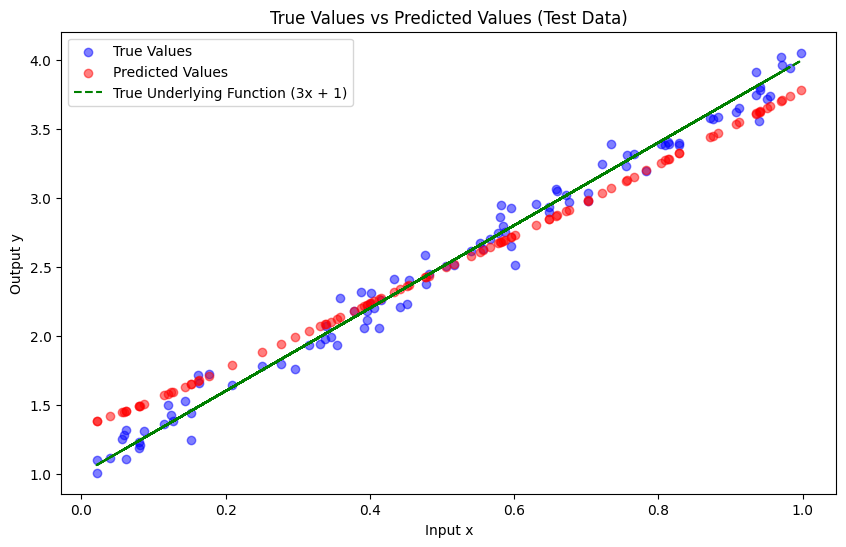

In [ ]:
import matplotlib.pyplot as plt
x_test = np.random.rand(100, 1).astype(np.float32)
y_test = 3 * x_test + 1 + np.random.randn(100, 1).astype(np.float32) * 0.1

x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

nets[0].eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = nets[0](x_test_tensor).cpu().numpy()

# Calculate Mean Squared Error (MSE) on test data
y_test_cpu = y_test_tensor.cpu().numpy()
mse = np.mean((y_pred - y_test_cpu) ** 2)
print(f'Mean Squared Error on test data: {mse:.4f}')

# Plot the true vs predicted values for test data
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test_cpu, label='True Values', color='blue', alpha=0.5)
plt.scatter(x_test, y_pred, label='Predicted Values', color='red', alpha=0.5)
plt.plot(x_test, 3 * x_test + 1, label='True Underlying Function (3x + 1)', color='green', linestyle='--')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()
plt.title('True Values vs Predicted Values (Test Data)')
plt.show()
